In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [36]:
SAVEDIR = "/workspace/mnt/local/data/pgurevich/magnitude"
datapath_magn = f"{SAVEDIR}/clf_results_magnitude.pkl"
datapath_embs = f"{SAVEDIR}/clf_results_embeddings.pkl"
datapath_both = f"{SAVEDIR}/clf_results_both.pkl"

with open(datapath_magn, 'rb') as f:
    results_magn = pkl.load(f)

with open(datapath_embs, 'rb') as f:
    results_embs = pkl.load(f)

with open(datapath_both, 'rb') as f:
    results_both = pkl.load(f)

In [37]:
#load the classifier results

aucs_magn = results_magn['aucs']
mistakes_magn = results_magn['mistakes']

aucs_embs = results_embs['aucs']
mistakes_embs = results_embs['mistakes']

aucs_both = results_both['aucs']
mistakes_both = results_both['mistakes']

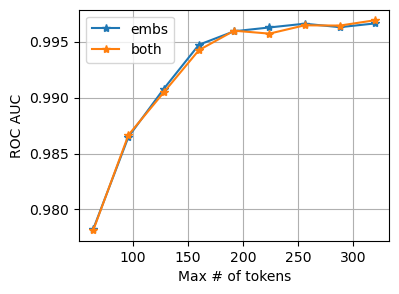

In [38]:
max_lengths = list(range(64, 321, 32))
plt.figure(figsize=(4, 3))
plt.plot(max_lengths, aucs_embs, marker='*', label='embs')
plt.plot(max_lengths, aucs_both, marker='*', label='both')
plt.legend()
plt.xlabel("Max # of tokens")
plt.ylabel("ROC AUC")
plt.grid()


In [39]:
DATA_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/small_data.csv"
data = pd.read_csv(DATA_PATH)
data

,text,label,prompt_name,source,RDizzl3_seven
0,"Hey there! \n\nSo, you know how sometimes you'...",1,Seeking multiple opinions,llama2_chat,False
1,\nThe Face on Mars is Merely a Natural Landfor...,1,The Face on Mars,darragh_claude_v6,True
2,I disagree with the principal's decision to re...,1,Mandatory extracurricular activities,darragh_claude_v7,False
3,**The Seagoing Cowboys: An Adventure of a Life...,1,"""A Cowboy Who Rode the Waves""",palm-text-bison1,True
4,Schools that offer distance learning is a open...,0,Distance learning,persuade_corpus,False
...,...,...,...,...,...
995,"Venus is considered as Earth's twin, so why no...",0,Exploring Venus,persuade_corpus,True
996,"Dear Senator,\n\nIts official, the electoral c...",0,Does the electoral college work?,persuade_corpus,True
997,Taking time to consider a career before enteri...,1,Seeking multiple opinions,mistral7binstruct_v1,False
998,Schools always want what is best for their stu...,0,Summer projects,persuade_corpus,False


In [40]:
from collections import defaultdict as ddict

def preprocess_mistakes(mistakes, names_set=None):
    mistakes_list = dict()
    if names_set is None:
        names_set = set()

    for i, m in enumerate(mistakes):
        for key, val in m.items():
            names_set.add(key)
            if key not in mistakes_list.keys():
                mistakes_list[key] = np.zeros(len(max_lengths))
            mistakes_list[key][i] = val

    for m in mistakes:
        for name in names_set:
            if name not in m.keys():
                m[name] = 0

    return mistakes, mistakes_list, names_set

mistakes_magn, mistakes_list, names_set = preprocess_mistakes(mistakes_magn)
mistakes_embs, mistakes_list_e, names_set = preprocess_mistakes(mistakes_embs, names_set)
mistakes_both, mistakes_list_b, names_set = preprocess_mistakes(mistakes_both, names_set)


Text(0, 0.5, 'FN ratio')

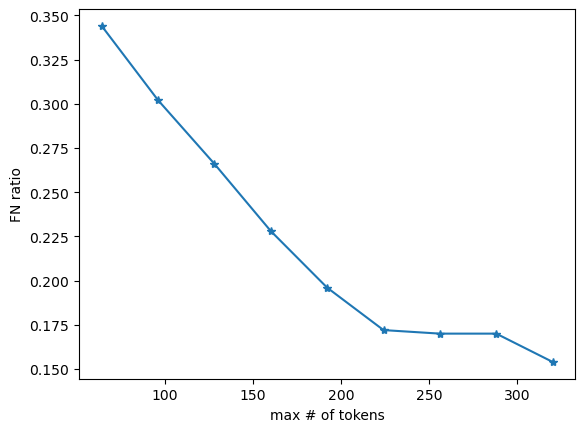

In [41]:
# plot the mean misclassification (FN ration)

mean_misclass = np.zeros(len(max_lengths))
for val in mistakes_list.values():
    mean_misclass += val
mean_misclass /= 500


plt.plot(max_lengths, mean_misclass, marker='*')
plt.xlabel("max # of tokens")
plt.ylabel("FN ratio")

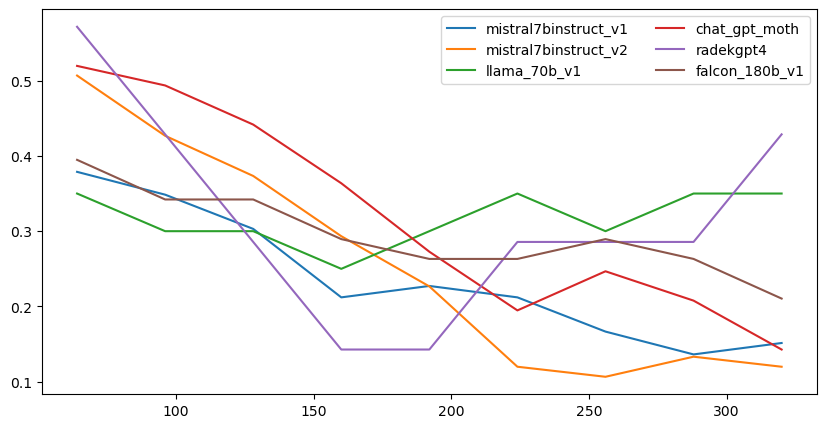

In [42]:
# Plot how misclassification changes for different LLMs

plt.figure(figsize=(10, 5))

for key, val in mistakes_list.items():
    val = val.astype(np.float32)
    num = data.source.value_counts().loc[key].astype(np.float32)
    val /= num
    if 0 not in val and val.max() > 0.34:
        plt.plot(max_lengths, val, label=key)

plt.legend(ncols=2);

In [43]:
def bar_mistakes(mistakes, i, data, inds, label):
    names, vals = mistakes[i].keys(), mistakes[i].values()
    vals = np.array(list(vals)).astype(np.float32)
    nums = np.array([data.source.value_counts().loc[x] for x in names]).astype(np.float32)
    vals /= nums
    names = np.array(list(names))
    plt.barh(names[inds], vals[inds], alpha=0.4, label=label)

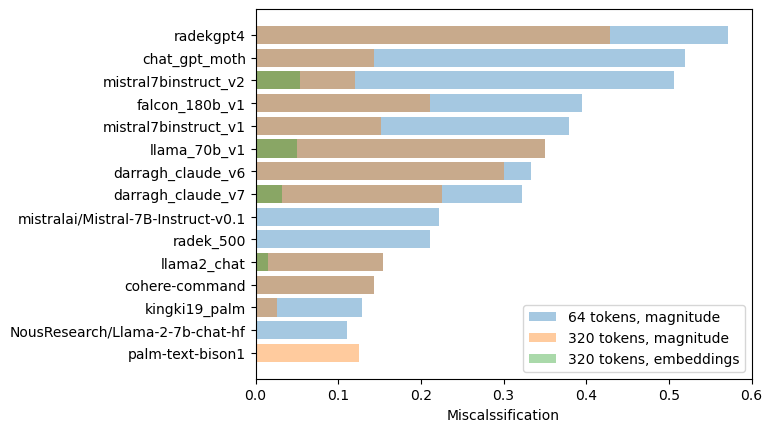

In [49]:
# Compare how mosclassification changes from 64 to 320 token size


vals = np.array(list(mistakes_magn[0].values())).astype(np.float32)
nums = np.array([data.source.value_counts().loc[x] for x in mistakes_magn[0].keys()]).astype(np.float32)
vals /= nums
inds = np.argsort(vals)

bar_mistakes(mistakes_magn, 0, data, inds, "64 tokens, magnitude")
bar_mistakes(mistakes_magn, -1, data, inds, "320 tokens, magnitude")
bar_mistakes(mistakes_embs, -1, data, inds, "320 tokens, embeddings")
plt.xlabel("Miscalssification")
plt.legend();